In [1]:
!pip install opencv-python

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2
import os
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import random
#from keras.losses import SparseCategoricalCrossentropy

2024-12-08 13:49:15.689447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 13:49:15.728425: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 13:49:15.739778: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 13:49:15.927330: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import pandas as pd
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split 
#from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
#import plotly.express as px
import random
#from keras.losses import SparseCategoricalCrossentropy
from collections import Counter
import seaborn as sns
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
#from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
#from keras import Layers
#from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout


In [4]:
def augment_with_rotation(image, label, rotation_angles=[0, 90, 180, 270]):
    """
    Augments an image by rotating it to specified angles.
    Returns augmented images and their associated labels.
    """
    augmented_images = []
    augmented_labels = []
    for angle in rotation_angles:
        # Rotate the image
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h), borderMode=cv2.BORDER_REFLECT)

        # Append the rotated image and the same label
        augmented_images.append(rotated_image)
        augmented_labels.append(label)

    return augmented_images, augmented_labels

In [5]:
def fetch_image_with_rotation_and_visualization(data_folder, rotation_angles=[0, 90, 180, 270]):
    """
    Fetch images, perform detection (crop based on bounding boxes), apply rotation augmentation,
    and resize to fit the classifier's input. Also visualizes sample augmented images.
    """
    train_data = []
    test_data = []
    valid_data = []
    cropped_samples = []  # To store a few sample cropped images for visualization
    
    splits = {
        "train": os.path.join(data_folder, "train"),
        "test": os.path.join(data_folder, "test"),
        "valid": os.path.join(data_folder, "valid")
    }
    
    for split_name, split_path in splits.items():
        images_folder = os.path.join(split_path, "images")
        labels_folder = os.path.join(split_path, "labels")
        
        for image_name in os.listdir(images_folder):
            label_name = os.path.splitext(image_name)[0] + ".txt"
            label_path = os.path.join(labels_folder, label_name)
            image_path = os.path.join(images_folder, image_name)
            
            if not os.path.exists(label_path):
                print(f"Warning: Label file not found for {image_name}")
                continue
            
            # Load the image without converting to grayscale
            img = Image.open(image_path)
            image_width, image_height = img.size
            img = np.array(img)

            # Parse the label file for bounding boxes
            with open(label_path, "r") as label_file:
                lines = label_file.readlines()
                for line in lines:
                    parts = line.strip().split()
                    class_id = int(parts[0])  # First value is the class ID
                    
                    # Parse normalized bounding box values
                    x_center, y_center, width, height = map(float, parts[1:])
                    
                    # Convert to pixel coordinates
                    x_min = int((x_center - width / 2) * image_width)
                    y_min = int((y_center - height / 2) * image_height)
                    x_max = int((x_center + width / 2) * image_width)
                    y_max = int((y_center + height / 2) * image_height)

                    # Crop the detected region
                    cropped_img = img[y_min:y_max, x_min:x_max]
                    
                    # Resize to match classifier input
                    resized_img = cv2.resize(cropped_img, (90, 90), interpolation=cv2.INTER_AREA)
                    
                    # Normalize the image
                    resized_img = resized_img / 255.0
                    
                    # Augment the image with rotations
                    augmented_images, augmented_labels = augment_with_rotation(resized_img, class_id, rotation_angles)
                    
                    # Store augmented images in the corresponding split
                    if split_name == "train":
                        train_data.extend(zip(augmented_images, augmented_labels))
                    elif split_name == "test":
                        test_data.extend(zip(augmented_images, augmented_labels))
                    elif split_name == "valid":
                        valid_data.extend(zip(augmented_images, augmented_labels))
    
    # Visualize a few augmented images
    plt.figure(figsize=(10, 10))
    for i in range(min(5, len(train_data))):  # Visualize up to 5 samples
        plt.subplot(1, 5, i + 1)
        plt.imshow(train_data[i][0])
        plt.axis('off')
    plt.show()

    return train_data, test_data, valid_data

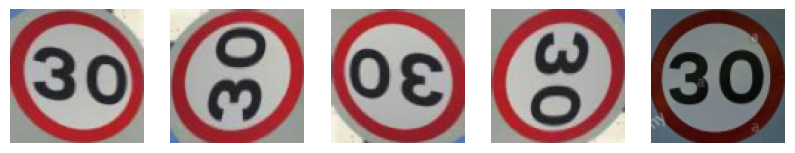

In [6]:
# Fetch and augment the dataset
data_folder = "./DataSet"
train_data, test_data, valid_data = fetch_image_with_rotation_and_visualization(data_folder)

In [ ]:
# Prepare training data features and labels
training_data_features, training_data_labels = zip(*train_data)
training_data_features = np.array(training_data_features).reshape(-1, 90, 90, 3)  # Add channel dimension
training_data_labels = np.array(training_data_labels)

# Prepare validation data
validation_data_features, validation_data_labels = zip(*valid_data)
validation_data_features = np.array(validation_data_features).reshape(-1, 90, 90, 3)
validation_data_labels = np.array(validation_data_labels)

# Prepare test data
test_data_features, test_data_labels = zip(*test_data)
test_data_features = np.array(test_data_features).reshape(-1, 90, 90, 3)
test_data_labels = np.array(test_data_labels)

In [ ]:
# Check the shape of features and labels
print(f"Training data features shape: {np.array(training_data_features).shape}")
print(f"Training data labels shape: {np.array(training_data_labels).shape}")

In [ ]:
unique_labels, label_counts = np.unique(training_data_labels, return_counts=True)
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} occurrences")

In [ ]:
cnnModel = Sequential()
cnnModel.add(Conv2D(16,(3,3), padding="same", input_shape=(90, 90, 3), activation='relu'))
print(cnnModel(training_data_features).shape)
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(32,(3,3), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(64,(5,5), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(128,(7,7), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Flatten())
cnnModel.add(Dense(232, activation='relu'))
cnnModel.add(Dense(116, activation='relu'))
cnnModel.add(Dense(15, activation='softmax'))

In [ ]:
cnnModel.summary()

In [ ]:
cnnModel.compile(optimizer='adam',                  
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

In [ ]:
# Train the model
SignTraffic = cnnModel.fit(
    training_data_features, 
    training_data_labels, 
    validation_data=(validation_data_features, validation_data_labels),
    epochs=10, 
    batch_size=32
)

In [ ]:
import seaborn as sns
sns.lineplot(SignTraffic.history['accuracy'])

In [ ]:
import matplotlib.pyplot as plt
# Assuming history is the result of the model's fit() method
plt.plot(SignTraffic.history['accuracy'], label='Training Accuracy')
plt.plot(SignTraffic.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(SignTraffic.history['loss'], label='Training Loss')
plt.plot(SignTraffic.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the labels on the test data
test_predictions = cnnModel.predict(test_data_features)
# Convert predictions from probabilities to class labels (use argmax to get the index of the highest probability)
test_predictions = np.argmax(test_predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_data_labels, test_predictions)

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_data_labels), yticklabels=np.unique(test_data_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate metrics for each class
for i in range(cm.shape[0]):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp  # sum of the column - TP
    fn = cm[i, :].sum() - tp  # sum of the row - TP
    tn = cm.sum() - (tp + fp + fn)
    
    # Calculate Precision, Recall, F1-Score, and Accuracy
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    print(f"Class {i}:")
    print(f"True Positive (TP): {tp}")
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")
    print(f"True Negative (TN): {tn}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_data_labels, test_predictions))

In [ ]:
cnnModel.save("model.h5")

In [ ]:
cnnModel.save("model.keras")

In [ ]:
from PIL import Image
import numpy as np

def preprocess_image(image_path):
    img = Image.open(image_path)
    print(f"Original Image Size: {img.size}")
    img = img.resize((90, 90))
    img_array = np.array(img)
    # If the image is grayscale (2D array), convert it to 3 channels (RGB)
    if len(img_array.shape) == 2:  # Grayscale image (2D array)
        img_array = np.stack([img_array] * 3, axis=-1)
    
    img_array = img_array / 255.0
    img_array = img_array.reshape(-1, 90, 90, 3)
    print(f"Image Resize: {img_array.shape}")
    return img_array

In [ ]:
def predict_image(image_path, model):
    img_array = preprocess_image(image_path)   
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_probability = np.max(predictions, axis=1)[0]
    return predicted_class, predicted_probability

In [ ]:
# Example usage
test_path = r"test_img\40_2.jpg" 
expected_size=(90, 90)
predicted_class, predicted_probability = predict_image(test_path, cnnModel)
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Probability: {predicted_probability:.4f}")
# Display the image
img = Image.open(test_path)
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.title(f"Class: {predicted_class}, Probability: {predicted_probability:.4f}")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Assuming your data is in the form of (image, label) pairs:
# Example: train_data = [(image1, class_id1), (image2, class_id2), ...]
# Replace 'train_data', 'valid_data', 'test_data' with your actual datasets.

# Count the number of samples per class in each dataset
train_class_counts = Counter(class_id for _, class_id in train_data)
valid_class_counts = Counter(class_id for _, class_id in valid_data)
test_class_counts = Counter(class_id for _, class_id in test_data)

# Sort the counts for consistent visualization
train_classes, train_num_of_samples = zip(*sorted(train_class_counts.items()))
valid_classes, valid_num_of_samples = zip(*sorted(valid_class_counts.items()))
test_classes, test_num_of_samples = zip(*sorted(test_class_counts.items()))

# Plot the distributions for all splits
plt.figure(figsize=(16, 8))

# Training Dataset
plt.subplot(3, 1, 1)
plt.bar(train_classes, train_num_of_samples, color='skyblue')
plt.title("Distribution of the Training Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(train_classes)

# Validation Dataset
plt.subplot(3, 1, 2)
plt.bar(valid_classes, valid_num_of_samples, color='lightgreen')
plt.title("Distribution of the Validation Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(valid_classes)

# Test Dataset
plt.subplot(3, 1, 3)
plt.bar(test_classes, test_num_of_samples, color='salmon')
plt.title("Distribution of the Test Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(test_classes)

# Show the combined plot
plt.tight_layout()
plt.show()